In [7]:
import mediapipe as mp
import cv2
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.misc import derivative
from scipy.signal import find_peaks
from statistics import stdev,mean
from scipy.interpolate import interp1d
import itertools as itr
import statistics
import pprint, pickle
from scipy.stats import binom
from scipy import signal

# definitions

In [23]:
#Parameter definitions

def pelvic_obliquity(x23,x24,y23,y24):
    output=math.atan((abs(y23-y24))/(abs(x23-x24)))
    return output

def step_width(x11,x12,x23,x24,y11,y12,y23,y24,x29,x30):
    step_width=abs(x30 - x29)
    body_length = math.sqrt((((x11+x12)/2)-((x23+x24)/2))**2+(((y11+y12)/2)-((y23+y24)/2))**2)
    output = step_width/body_length
    #output = step_wid
    return output

def foot_lifting(y28,y27,x11,x12,x23,x24,y11,y12,y23,y24):
    body_length = math.sqrt((((x11+x12)/2)-((x23+x24)/2))**2+(((y11+y12)/2)-((y23+y24)/2))**2)
    output=(y28 - y27)/body_length
    return output

def hip_ankle_right(y28,x11,x12,x23,x24,y11,y12,y23,y24):
    body_length = math.sqrt((((x11+x12)/2)-((x23+x24)/2))**2+(((y11+y12)/2)-((y23+y24)/2))**2)
    output = abs(y24-y28)/body_length
    return output

def hip_ankle_left(y27,x11,x12,x23,x24,y11,y12,y23,y24):
    body_length = math.sqrt((((x11+x12)/2)-((x23+x24)/2))**2+(((y11+y12)/2)-((y23+y24)/2))**2)
    output = abs(y23-y27)/body_length
    return output
def upl(x11,x12,x23,x24,y11,y12,y23,y24):
    body_length = math.sqrt((((x11+x12)/2)-((x23+x24)/2))**2+(((y11+y12)/2)-((y23+y24)/2))**2)
    return body_length

#Other definitions

def get_valleys(df,y,p):
    valley, _ = find_peaks(-y,prominence=p)
    plt.figure(figsize=(100,5))
    plt.plot(df.t,y)
    plt.plot(df.t[valley], y[valley],"X",markerfacecolor='red',markersize=8)
    plt.show()
    return valley

def get_peaks(df,y,p):
    peak, _ = find_peaks(y,prominence=p)
    plt.figure(figsize=(100,5))
    plt.plot(df.t,y)
    plt.plot(df.t[peak], y[peak], "X",markerfacecolor='red',markersize=8)
    plt.show()
    return peak

def com(A,B):
    if type(A)==np.ndarray:
        C= A.tolist()
    else:
        C=A
    for i,v in enumerate(B):
        C.insert(2*i+1,v) 
    return C

def time_diff(peaks, df):
    array=[]
    for i in range(len(peaks)-1):
        td=df.t[peaks[i+1]]-df.t[peaks[i]]
        array.append(td)
    return array


def distribution(data):
    ax=sns.distplot(data,
                kde=True,
                bins=8,
                color='blue',
                hist_kws={"linewidth": 22,'alpha':0.60})
    ax.set(xlabel='Binomial',ylabel='Frequency')
    plt.show()
    
def remove_time_gap(data):
    from statistics import stdev,mean
    SD=stdev(data)
    m= mean(data)
 
    cut_off = SD * 0.5
    upper =  m + cut_off
    array = [x for x in data if x < upper]
    return array

def remove_distinct_peaks(array,df,Time_to_index_ratio,y,p,m):
    modified_mean= mean(array)
    Distance=Time_to_index_ratio*modified_mean*m
    
    print(Distance)
    
    peaks, _ = find_peaks(y,prominence=p,distance=Distance)
    plt.figure(figsize=(100,5))
    plt.plot(df.t,y)
    plt.plot(df.t[peaks], y[peaks],"X",markerfacecolor='red',markersize=8)
    plt.show()
    return peaks

def remove_distinct_valleys(array,df,Time_to_index_ratio,y,p,m):
    modified_mean= mean(array)
    Distance=Time_to_index_ratio*modified_mean*m
    
    valleys, _ = find_peaks(-y,prominence=p,distance=Distance)
    plt.figure(figsize=(100,5))
    plt.plot(df.t,y)
    plt.plot(df.t[valleys], y[valleys],"X",markerfacecolor='red',markersize=8)
    plt.show()
    return valleys

def sample(df,y,peak,time_return_points):
    a = np.array(df.t[peak])
    sample_max=[]
    for i in range(len(time_return_points)-1):
        index=np.where(np.logical_and(a>=time_return_points.t[i], a<=time_return_points.t[i+1]))
        s = list(map(lambda a : y[peak[a]], index[0]))
        sample_max.append(s)
    return sample_max

def max_avg(peaks_array):
    maximum=[]
    for m in peaks_array:
        if sum(m)==0:
            maximum.append([])
        if sum(m)!=0:
            average=sum(m)/len(m)
            maximum.append(average)
    return maximum

def maximum(peaks_array):
    maximum=[]
    for m in peaks_array:
        if sum(m)==0:
            maximum.append([])
        if sum(m)!=0:
            maximum.append(max(m))
    return maximum

def sequence(df,valley,time_return_points,n,y_data):
    a = np.array(df.t[valley])
    y_interp = interp1d(df.t,y_data)
    sample_max=[]
    for i in range(len(time_return_points)-1):
        index=np.where(np.logical_and(a>=time_return_points.t[i], a<=time_return_points.t[i+1]))
        s = list(map(lambda a : valley[a], index[0]))
        sample_max.append(s)
        sam_t=[]
        if len(sample_max)!=0:
            m=len(sample_max)-1
            t=sample_max[0]
            #calculate sample width
            s_width=(sample_max[m]-sample_max[0])/n
            for i in range(n):
                sam_t.append(t)
                t=t+s_width
            #find y values to corresponding sampling t values
            y=y_interp(sam_t)
            seq.append(y)
        if len(s)==0:
            seq.append([])
    return s, seq


def com(A,B):
    if type(A)==np.ndarray:
        C= A.tolist()
    else:
        C=A
    for i,v in enumerate(B):
        C.insert(2*i+1,v) 
    return C
def comb_dir_arrays(plus_array,minus_array,plus,minus):   
    if plus<minus:
        array=com(plus_array,minus_array)
    elif plus>minus:
        array=com(minus_array,plus_array)
    return array

def strides(sample_strikes):
    strides=[]
    for strike in sample_strikes:
        sample=[]
        for i in range(len(strike)-1):
            t_diff=abs(strike[i+1]-strike[i])
            sample.append(t_diff)
        strides.append(sample)
    return strides

def sv(df,peak,time_return_points,key_array):
    a = np.array(df.t[peak])
    sample_max=[]
    for i in range(len(time_return_points)-1):
        index=np.where(np.logical_and(a>=time_return_points.t[i], a<=time_return_points.t[i+1]))
        s = list(map(lambda a : key_array[peak[a]][0][0], index[0]))
        sample_max.append(s)
    return sample_max

def remove_time_gap(data):
    from statistics import stdev,mean
    SD=stdev(data)
    m= mean(data)
 
    cut_off = SD * 0.5
    upper =  m + cut_off
    array = [x for x in data if x < upper]
    return array

def sample_time(df,strike_peak,time_return_points):
    a = np.array(df.t[strike_peak])
    sample_strikes=[]
    for i in range(len(time_return_points)-1):
        index=np.where(np.logical_and(a>=time_return_points.t[i], a<=time_return_points.t[i+1]))
        s = list(map(lambda a : df.t[strike_peak[a]], index[0]))
        sample_strikes.append(s)
    return sample_strikes

In [9]:
name='Geemanthi evidence 1'

f_file = open('{}'.format(name), 'rb')

key_array = pickle.load(f_file)
#pprint.pprint(fT)

f_file.close()

# Feature vector array -  front 

In [10]:
D_f = [[None], [None], [None, None], [None, None], [None], [None]]

# Upper body height

[[ 1.13750681e-01  1.65849103e+09  4.51641232e-02 ... -3.84358005e-02
   8.05183649e-02  1.25682488e-01]
 [ 1.21784359e-01  1.65849103e+09  4.00632024e-02 ... -2.43482186e-02
   7.94044882e-02  1.19467691e-01]
 [ 1.26749903e-01  1.65849103e+09  3.52599621e-02 ... -2.48146461e-02
   7.87951276e-02  1.14055090e-01]
 ...
 [ 1.31079689e-01  1.65849105e+09  2.81048417e-02 ... -1.51100066e-02
   9.50686216e-01  9.22581375e-01]
 [ 1.28992990e-01  1.65849105e+09  3.00464630e-02 ... -1.03495112e-02
   9.56391752e-01  9.26345289e-01]
 [ 1.26452729e-01  1.65849105e+09  3.30782533e-02 ... -6.90456107e-03
   9.63135660e-01  9.30057406e-01]]
          ubh             t        sl       sln    center     r_sdr     l_sdr
0    0.113751  1.658491e+09  0.045164  0.397045 -0.038436  0.080518  0.125682
1    0.121784  1.658491e+09  0.040063  0.328968 -0.024348  0.079404  0.119468
2    0.126750  1.658491e+09  0.035260  0.278185 -0.024815  0.078795  0.114055
3    0.128524  1.658491e+09  0.032482  0.252728 -0.0

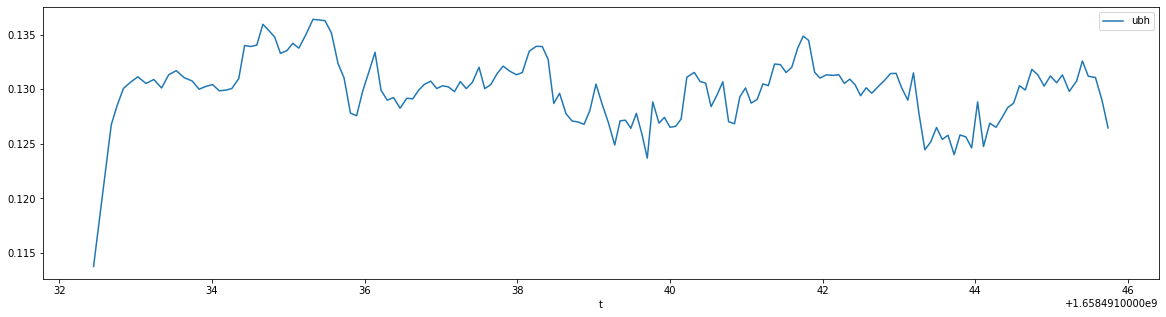

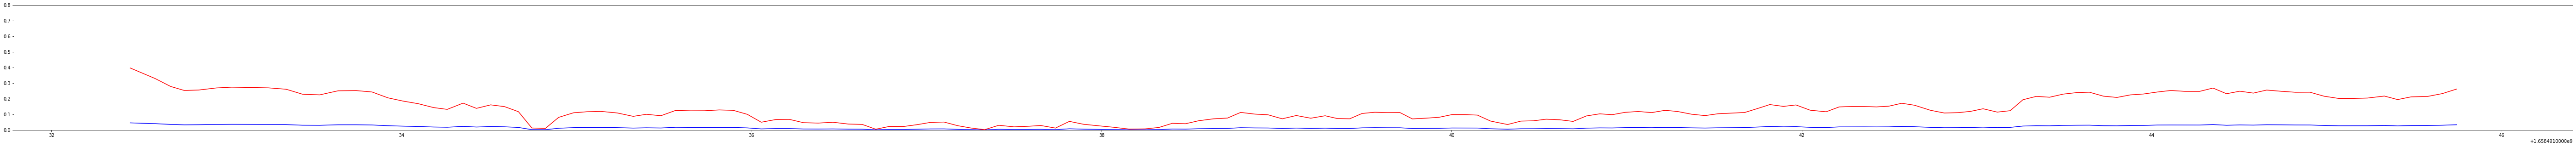

In [11]:
H=[]
for i in range(len(key_array)):
    #time
    t=key_array[i][12][3]
    #upper body height
    ubh=abs((key_array[i][11][1]+key_array[i][12][1])-(key_array[i][23][1]+key_array[i][24][1]))/2
    #shoulder length
    sl=abs(key_array[i][11][0]-key_array[i][12][0])
    #center of upper body in depth
    center=(key_array[i][11][2]+key_array[i][12][2]+key_array[i][23][2]+key_array[i][24][2])/4
    
    #
    heel_r=abs(key_array[i][24][1]-key_array[i][30][1])
    foot_index_r=abs(key_array[i][24][1]-key_array[i][32][1])
    heel_l=abs(key_array[i][23][1]-key_array[i][29][1])
    foot_index_l=abs(key_array[i][23][1]-key_array[i][31][1])
    #sldir=key_array[i][11][0]-key_array[i][12][0]
    right=key_array[i][12][0]
    left=key_array[i][11][0]
    H.append([ubh])
    H[i].append(t)
    H[i].append(sl)
    H[i].append(sl/ubh)
    H[i].append(center)
    H[i].append(right)
    H[i].append(left)
    #H[i].append(sldir)
H_array = np.array(H)
print(H_array)

df = pd.DataFrame(H_array,columns=['ubh','t','sl','sln','center','r_sdr','l_sdr'])
print(df)

df.plot(x ='t', y='ubh', kind = 'line',figsize=(20,5))
#plt.ylim(0,0.2)
plt.show()

plt.figure(figsize=(100,5))
plt.plot(df.t,df.sl,'b')
plt.plot(df.t,df.sln,'r')
plt.ylim(0,0.8)
plt.show()

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


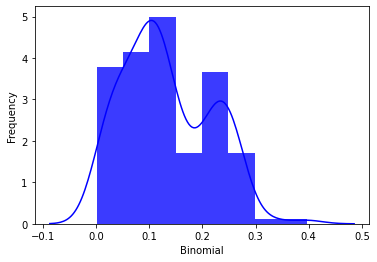

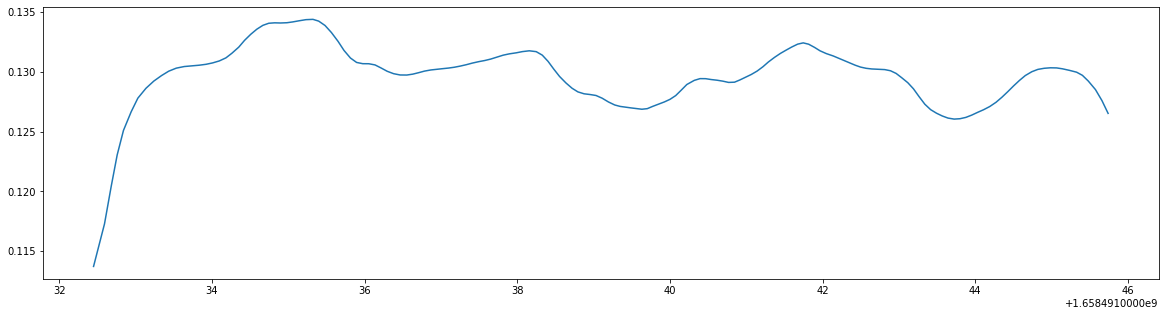

In [12]:

data=df.sln
ax=sns.distplot(data,
                kde=True,
                color='blue',
                hist_kws={"linewidth": 22,'alpha':0.77})
ax.set(xlabel='Binomial',ylabel='Frequency')
plt.show()

b, a = signal.butter(1, 0.1, btype='lowpass', analog=False)
low_passed = signal.filtfilt(b, a, df.ubh)

plt.figure(figsize=(20,5))
plt.plot(df.t,low_passed)
plt.show()

# walking direction

Normalized shoulder length


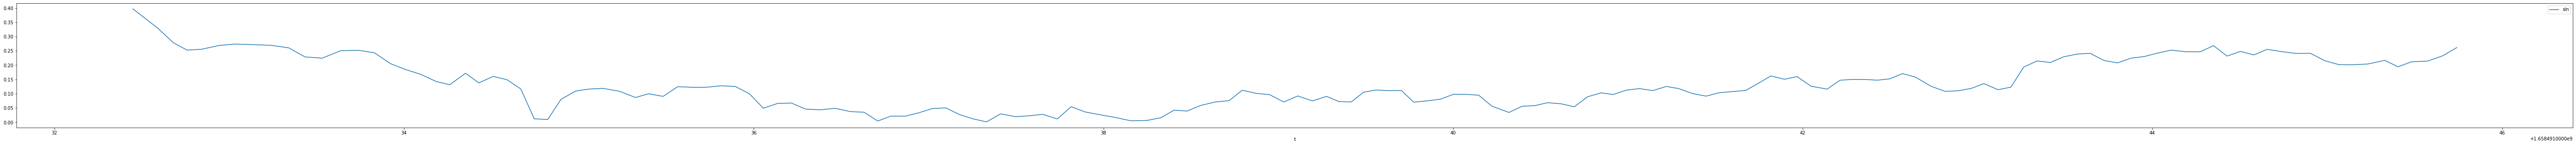

Empty DataFrame
Columns: [index, t]
Index: []


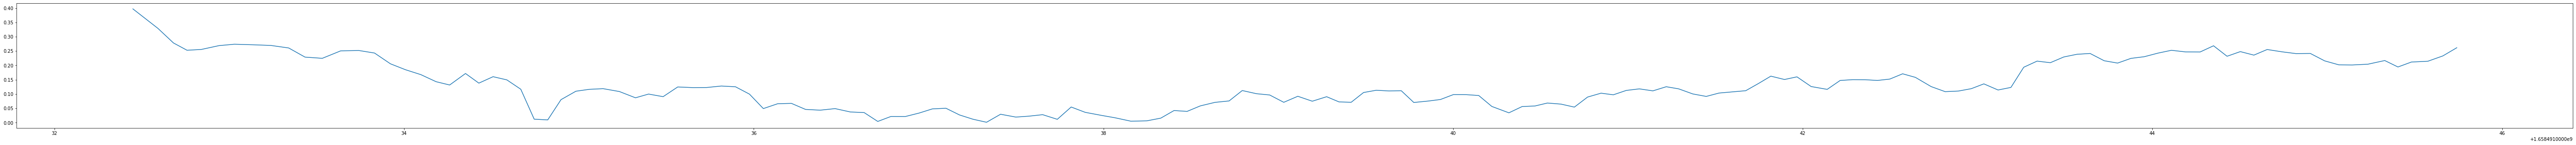

Right and left shoulder points variations


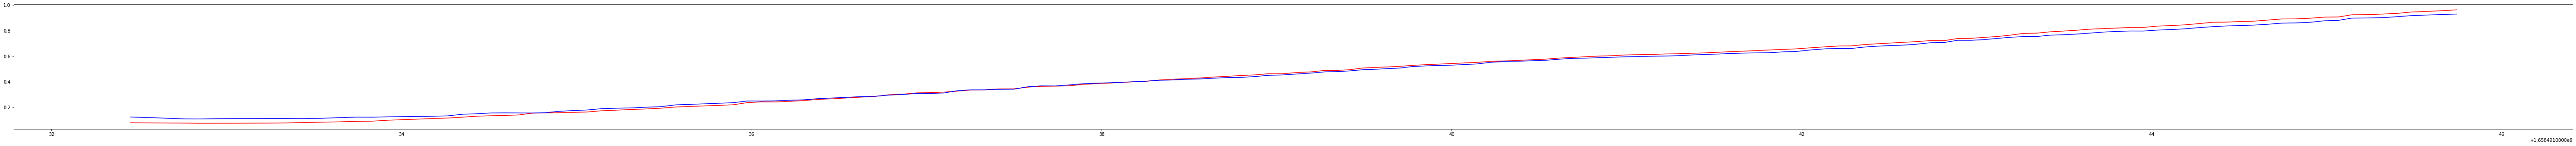

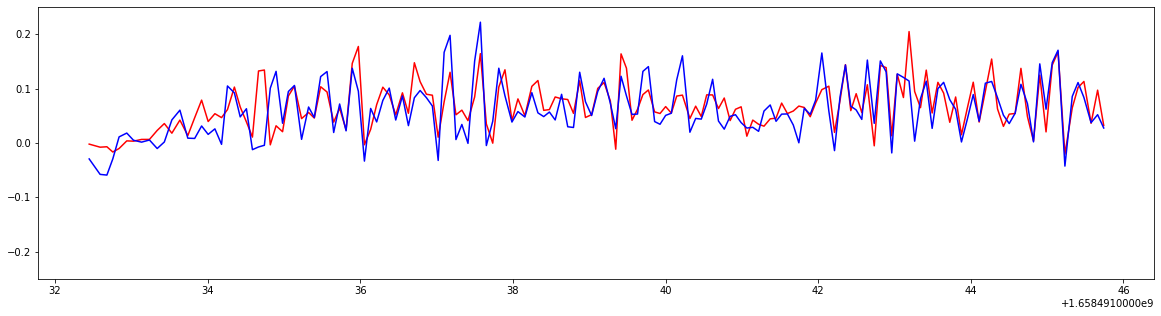

IndexError: index 0 is out of bounds for axis 0 with size 0

In [13]:
print ("Normalized shoulder length")
df.plot(x ='t', y='sln', kind = 'line',figsize=(100,5))
#plt.ylim(0,0.2)
plt.show()

return_points,_=find_peaks(-df.sln,prominence=0.5)
time_return_points=pd.DataFrame(df.t[return_points],columns=['t']).reset_index()
print(time_return_points)
plt.figure(figsize=(100,5))
plt.plot(df.t,df.sln)
plt.plot(df.t[return_points], df.sln[return_points],"X",markerfacecolor='red',markersize=8)
plt.show()

return_points_L =return_points[1::2]

print ("Right and left shoulder points variations")
plt.figure(figsize=(100,5))
plt.plot(df.t,df.r_sdr,'r')
plt.plot(df.t,df.l_sdr,'b')
plt.plot(df.t[return_points], df.r_sdr[return_points],"X",markerfacecolor='red',markersize=8)
plt.plot(df.t[return_points], df.l_sdr[return_points],"X",markerfacecolor='black',markersize=8)
plt.show()

#if right shoulder value <left shoulder ,then man walking towards(front)

from scipy.interpolate import UnivariateSpline

spl = UnivariateSpline(df.t, df.r_sdr, k=4, s=0)
r_sdr_diff= spl.derivative()
spl = UnivariateSpline(df.t, df.l_sdr, k=4, s=0)
l_sdr_diff= spl.derivative()

plt.figure(figsize=(20,5))
plt.ylim(-0.25,0.25)
plt.plot(df.t,r_sdr_diff(df.t),'r')
plt.plot(df.t,l_sdr_diff(df.t),'b')
plt.plot(df.t[return_points], r_sdr_diff(df.t)[return_points],"X",markerfacecolor='green',markersize=8)
plt.plot(df.t[return_points], l_sdr_diff(df.t)[return_points],"X",markerfacecolor='black',markersize=8)
plt.show()

diff_r=r_sdr_diff(df.t)[return_points]
diff_l=l_sdr_diff(df.t)[return_points]

if diff_r[0]>diff_l[0]:
    return_points_front = return_points[::2]
    return_points_back = return_points[1::2]
    plus = 1
    minus = 0
elif diff_l[0]>diff_r[0]:
    return_points_front = return_points[1::2]
    return_points_back = return_points[::2]
    plus = 0
    minus = 1
else:
    print('error')

In [16]:
plus=0
minus=1

# Pelvic obliquity

            po             t     r_sdr     l_sdr
0    13.128351  1.658491e+09  0.080518  0.125682
1     1.081607  1.658491e+09  0.079404  0.119468
2     3.228177  1.658491e+09  0.078795  0.114055
3     4.657932  1.658491e+09  0.077932  0.110414
4     6.725356  1.658491e+09  0.076542  0.109789
..         ...           ...       ...       ...
161  12.336581  1.658491e+09  0.935381  0.909601
162  11.205089  1.658491e+09  0.945432  0.917662
163  10.870674  1.658491e+09  0.950686  0.922581
164  17.176037  1.658491e+09  0.956392  0.926345
165  15.084661  1.658491e+09  0.963136  0.930057

[166 rows x 4 columns]
Splited data set
            po             t     r_sdr     l_sdr
0    13.128351  1.658491e+09  0.080518  0.125682
1     1.081607  1.658491e+09  0.079404  0.119468
2     3.228177  1.658491e+09  0.078795  0.114055
3     4.657932  1.658491e+09  0.077932  0.110414
4     6.725356  1.658491e+09  0.076542  0.109789
..         ...           ...       ...       ...
161  12.336581  1.658491e+09

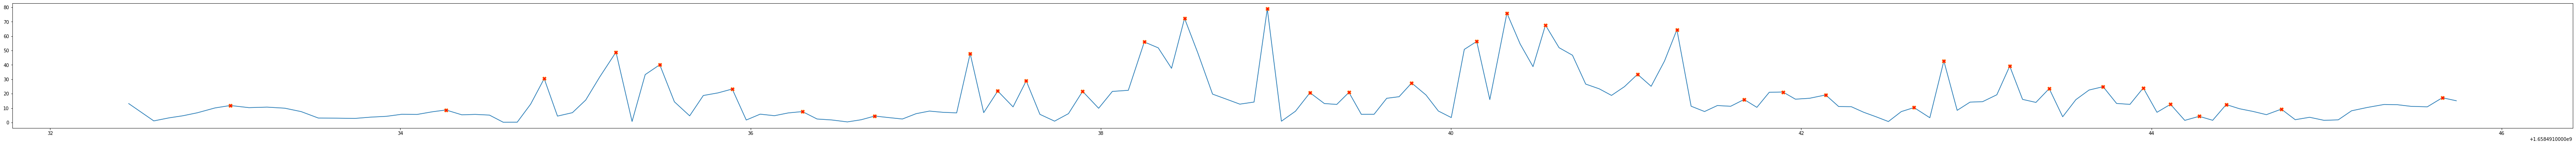

10.55681753278171
Outlier removed graphs
1.1112889389394527


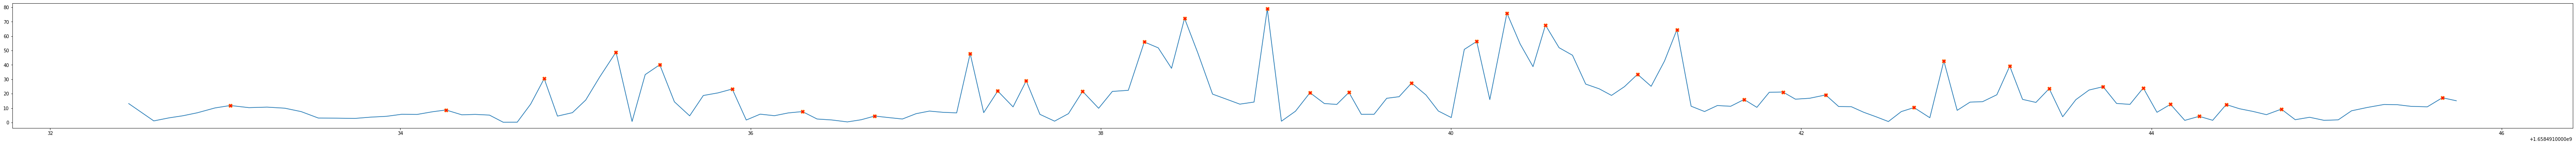

[]
[]
Instance data
[]
[]
0


In [35]:
P_O=[]

for i in range(len(key_array)):
    t=key_array[i][28][3]
    po=math.degrees(pelvic_obliquity(key_array[i][23][0],key_array[i][24][0],key_array[i][23][1],key_array[i][24][1]))
    right = key_array[i][12][0]
    left = key_array[i][11][0]
    P_O.append([po])
    P_O[i].append(t)
    P_O[i].append(right)
    P_O[i].append(left)
    
pelvic = np.array(P_O)

df_po = pd.DataFrame(pelvic,columns=['po','t','r_sdr','l_sdr'])
print(df_po)



print ("Splited data set")
if plus==1:
    df_foward=df_po
    print(df_foward)
    peaks_foward=get_peaks(df_foward,df_foward.po,3)
    
    Time_to_index_ratio=(peaks_foward[1]-peaks_foward[0])/(df.t[peaks_foward[1]]-df.t[peaks_foward[0]])
    
    print("Outlier removed graphs")
    df_foward_time=time_diff(peaks_foward,df_foward)
    foward_peaks_po=remove_distinct_peaks(df_foward_time,df_foward,Time_to_index_ratio,df_foward.po,3,0.3)
    foward_peaks_sets=sample(df_foward,df_foward.po,foward_peaks_po,time_return_points)
    print(foward_peaks_sets)
    
    print ("Outlier removed set")
    new_foward_peaks_sets=[]
    for i in range(len(foward_peaks_sets)):
        new2=[]
        for j in range(len(foward_peaks_sets[i])):       
            if foward_peaks_sets[i][j]<10:
                new2.append(foward_peaks_sets[i][j])
        new_foward_peaks_sets.append(new2) 
        
    print (new_foward_peaks_sets)
    
    print ("Instance data")
    po_foward=list((map(lambda a : np.mean(a), new_foward_peaks_sets)))
    print(po_foward)
    
    D1=po_foward
    
    
if minus==1:
    df_backward=df_po
    print(df_backward)
    peaks_backward=get_peaks(df_backward,df_backward.po,2)
    
    Time_to_index_ratio=(peaks_backward[1]-peaks_backward[0])/(df.t[peaks_backward[1]]-df.t[peaks_backward[0]])
    print(Time_to_index_ratio)
    
    print("Outlier removed graphs")
    df_backward_time=time_diff(peaks_backward,df_backward)
    backward_peaks_po=remove_distinct_peaks(df_backward_time,df_backward,Time_to_index_ratio,df_backward.po,2,0.3)
    backward_peaks_sets=sample(df_backward,df_backward.po,backward_peaks_po,time_return_points)
    print(backward_peaks_sets)

       

    new_backward_peaks_sets=[]
    for i in range(len(backward_peaks_sets)):
        new2=[]
        for j in range(len(backward_peaks_sets[i])):      
            if backward_peaks_sets[i][j]<10:
                new2.append(backward_peaks_sets[i][j])
        new_backward_peaks_sets.append(new2) 
    
    print (new_backward_peaks_sets)

    print ("Instance data")
    po_backward=list((map(lambda a : np.mean(a), new_backward_peaks_sets)))

    print(po_backward)
    
    D1=po_backward

print (D1)
print (len(D1))
D_f[0]=D1

# Step width

            sw             t     r_sdr     l_sdr
0     6.670007  1.658491e+09  0.080518  0.125682
1     6.946278  1.658491e+09  0.079404  0.119468
2     6.481501  1.658491e+09  0.078795  0.114055
3     6.446343  1.658491e+09  0.077932  0.110414
4     6.502647  1.658491e+09  0.076542  0.109789
..         ...           ...       ...       ...
161  37.751707  1.658491e+09  0.935381  0.909601
162  37.026320  1.658491e+09  0.945432  0.917662
163  34.530778  1.658491e+09  0.950686  0.922581
164  31.784322  1.658491e+09  0.956392  0.926345
165  28.843481  1.658491e+09  0.963136  0.930057

[166 rows x 4 columns]
            sw             t     r_sdr     l_sdr
0     6.670007  1.658491e+09  0.080518  0.125682
1     6.946278  1.658491e+09  0.079404  0.119468
2     6.481501  1.658491e+09  0.078795  0.114055
3     6.446343  1.658491e+09  0.077932  0.110414
4     6.502647  1.658491e+09  0.076542  0.109789
..         ...           ...       ...       ...
161  37.751707  1.658491e+09  0.935381  0.909

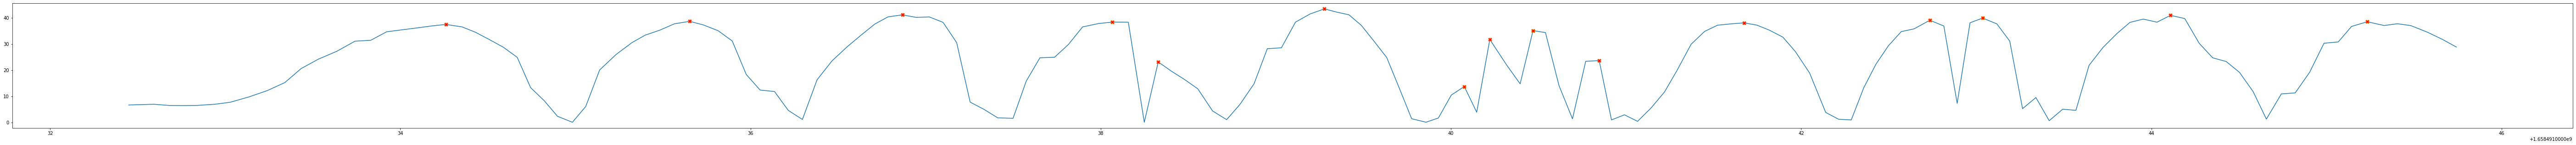

2.8720554147209056


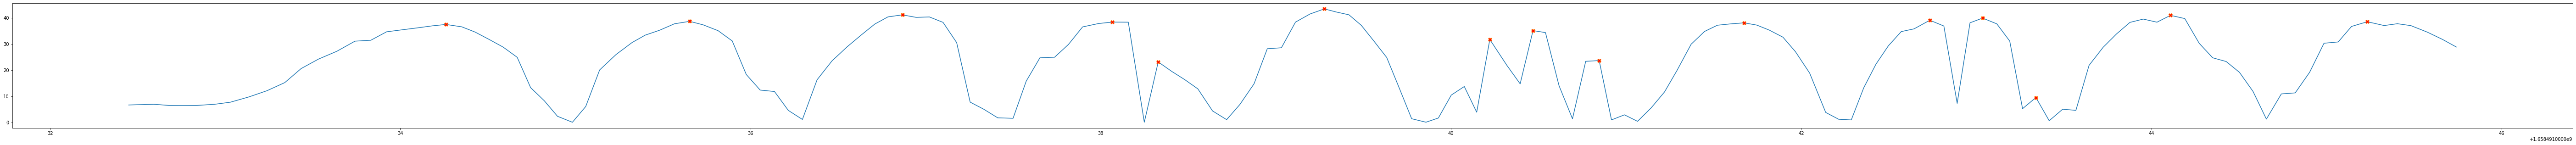

[]
[]
[]
[]
0


In [39]:
s_w=[]

for i in range(len(key_array)):
    t=key_array[i][28][3]
    sw=math.degrees(step_width(key_array[i][11][0],key_array[i][12][0],key_array[i][23][0],key_array[i][24][0],key_array[i][11][1],key_array[i][12][1],key_array[i][23][1],key_array[i][24][1],key_array[i][29][0],key_array[i][30][0]))
    right = key_array[i][12][0]
    left = key_array[i][11][0]
    s_w.append([sw])
    s_w[i].append(t)
    s_w[i].append(right)
    s_w[i].append(left)
    
width = np.array(s_w)

df_sw = pd.DataFrame(width,columns=['sw','t','r_sdr','l_sdr'])
print(df_sw)

if plus==1:
    df_foward=df_sw
    print(df_foward)
    peaks_foward=get_peaks(df_foward,df_foward.sw,5)
    Time_to_index_ratio=(peaks_foward[1]-peaks_foward[0])/(df.t[peaks_foward[1]]-df.t[peaks_foward[0]])
    
    print("Outlier removed")
    df_foward_time=time_diff(peaks_foward,df_foward)
    
    foward_peaks_sw=remove_distinct_peaks(df_foward_time,df_foward,Time_to_index_ratio,df_foward.sw,4,0.3)
    foward_peaks_sets=sample(df_foward,df_foward.sw,foward_peaks_sw,time_return_points)
    print(foward_peaks_sets)
    
    new_foward_peaks_sets=[]
    for i in range(len(foward_peaks_sets)):
        new2=[]
        for j in range(len(foward_peaks_sets[i])):       
            if foward_peaks_sets[i][j]<25:
                new2.append(foward_peaks_sets[i][j])
        new_foward_peaks_sets.append(new2)   
    print (new_foward_peaks_sets)
    print ("Instance data")
    sw_foward=list((map(lambda a : np.mean(a), new_foward_peaks_sets)))
    print(sw_foward)
    
    D2=sw_foward

if minus==1:
    df_backward=df_sw
    print(df_backward)
    peaks_backward=get_peaks(df_backward,df_backward.sw,5)
    Time_to_index_ratio=(peaks_backward[1]-peaks_backward[0])/(df.t[peaks_backward[1]]-df.t[peaks_backward[0]])
    
    df_backward_time=time_diff(peaks_backward,df_backward)
                             
    
    backward_peaks_sw=remove_distinct_peaks(df_backward_time,df_backward,Time_to_index_ratio,df_backward.sw,4,0.3)
    backward_peaks_sets=sample(df_backward,df_backward.sw,backward_peaks_sw,time_return_points)
    print(backward_peaks_sets)
    
    new_backward_peaks_sets=[]
    for i in range(len(backward_peaks_sets)):
        new2=[]
        for j in range(len(backward_peaks_sets[i])):      
            if backward_peaks_sets[i][j]<25:
                new2.append(backward_peaks_sets[i][j])
        new_backward_peaks_sets.append(new2) 


    print (new_backward_peaks_sets)
    
    sw_backward=list((map(lambda a : np.mean(a), new_backward_peaks_sets)))
    print(sw_backward)
    
    D2=sw_backward


print (D2)
print (len(D2))
D_f[1]=D2

# Foot lifting distance

In [40]:
Foot_lifting=[]

for i in range(len(key_array)):
    t=key_array[i][28][3]
    x1=foot_lifting(key_array[i][28][1],key_array[i][27][1],key_array[i][11][0],key_array[i][12][0],key_array[i][23][0],key_array[i][24][0],key_array[i][11][1],key_array[i][12][1],key_array[i][23][1],key_array[i][24][1])
    x2=foot_lifting(key_array[i][27][1],key_array[i][28][1],key_array[i][11][0],key_array[i][12][0],key_array[i][23][0],key_array[i][24][0],key_array[i][11][1],key_array[i][12][1],key_array[i][23][1],key_array[i][24][1])
    right = key_array[i][12][0]
    left = key_array[i][11][0]
    Foot_lifting.append([x1])
    Foot_lifting[i].append(x2)
    Foot_lifting[i].append(t)
    Foot_lifting[i].append(right)
    Foot_lifting[i].append(left)
Foot_lifting = np.array(Foot_lifting)

df_fl = pd.DataFrame(Foot_lifting,columns=['foot_right', 'foot_left','t','r_sdr','l_sdr'])
print(df_fl)

if plus==1:
    df_foward=df_fl 
    print(df_foward)

if minus==1:
    df_backward=df_fl
    print(df_backward)

     foot_right  foot_left             t     r_sdr     l_sdr
0      0.038963  -0.038963  1.658491e+09  0.080518  0.125682
1      0.031774  -0.031774  1.658491e+09  0.079404  0.119468
2      0.030613  -0.030613  1.658491e+09  0.078795  0.114055
3      0.034773  -0.034773  1.658491e+09  0.077932  0.110414
4      0.040338  -0.040338  1.658491e+09  0.076542  0.109789
..          ...        ...           ...       ...       ...
161    0.038929  -0.038929  1.658491e+09  0.935381  0.909601
162    0.147902  -0.147902  1.658491e+09  0.945432  0.917662
163    0.190013  -0.190013  1.658491e+09  0.950686  0.922581
164    0.260205  -0.260205  1.658491e+09  0.956392  0.926345
165    0.292946  -0.292946  1.658491e+09  0.963136  0.930057

[166 rows x 5 columns]
     foot_right  foot_left             t     r_sdr     l_sdr
0      0.038963  -0.038963  1.658491e+09  0.080518  0.125682
1      0.031774  -0.031774  1.658491e+09  0.079404  0.119468
2      0.030613  -0.030613  1.658491e+09  0.078795  0.114055


## Foot lifting right

In [41]:
if plus==0:
    peaks_foward=get_peaks(df_foward,df_foward.foot_right,0.4)
    print ("outlier removed")
    Time_to_index_ratio=(peaks_foward[1]-peaks_foward[0])/(df.t[peaks_foward[1]]-df.t[peaks_foward[0]])
    df_foward_time=time_diff(peaks_foward,df_foward)
    
    foward_peaks_fl_r=remove_distinct_peaks(df_foward_time,df_foward,Time_to_index_ratio,df_foward.foot_right,0.4,0.1)


    peaks_backward=get_peaks(df_backward,df_backward.foot_right,0.3)
    
    foward_peaks_sets=sample(df_foward,df_foward.foot_right,foward_peaks_fl_r,time_return_points)
    print(foward_peaks_sets)
#peaks = get_peaks(df_fl,df_fl.foot_right,0.2)
    
    new_foward_peaks_sets=[]
    for i in range(len(foward_peaks_sets)):
        new2=[]
        for j in range(len(foward_peaks_sets[i])):       
            if foward_peaks_sets[i][j]<0.6:
                new2.append(foward_peaks_sets[i][j])
        new_foward_peaks_sets.append(new2)   
    
    print (new_foward_peaks_sets)
    
    fl_r_foward=list((map(lambda a : np.mean(a), new_foward_peaks_sets)))
    print(fl_r_foward)
    
    D3=fl_r_foward

if minus==1:
    df_backward_time=time_diff(peaks_backward,df_backward)
    backward_peaks_fl_r=remove_distinct_peaks(df_backward_time,df_backward,Time_to_index_ratio,df_backward.foot_right,0.2,0.1)
    backward_peaks_sets=sample(df_backward,df_backward.foot_right,backward_peaks_fl_r,time_return_points)
    print(backward_peaks_sets)

    new_backward_peaks_sets=[]
    for i in range(len(backward_peaks_sets)):
        new2=[]
        for j in range(len(backward_peaks_sets[i])):      
            if backward_peaks_sets[i][j]<0.6:
                new2.append(backward_peaks_sets[i][j])
        new_backward_peaks_sets.append(new2) 
    

    print (new_backward_peaks_sets)
    fl_r_backward=list((map(lambda a : np.mean(a), new_backward_peaks_sets[minus::2])))

    print(fl_r_backward)
    
    D3=fl_r_backward


print (D3)
print (len(D3))
D_f[2][0]=D3

NameError: name 'df_foward' is not defined

## foot lifting left

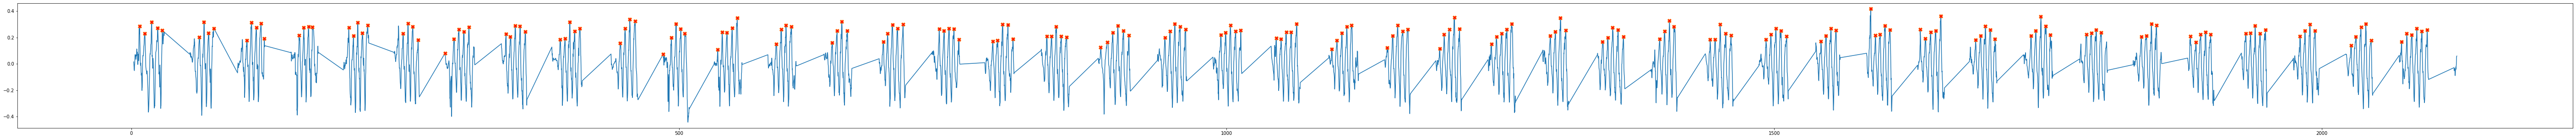

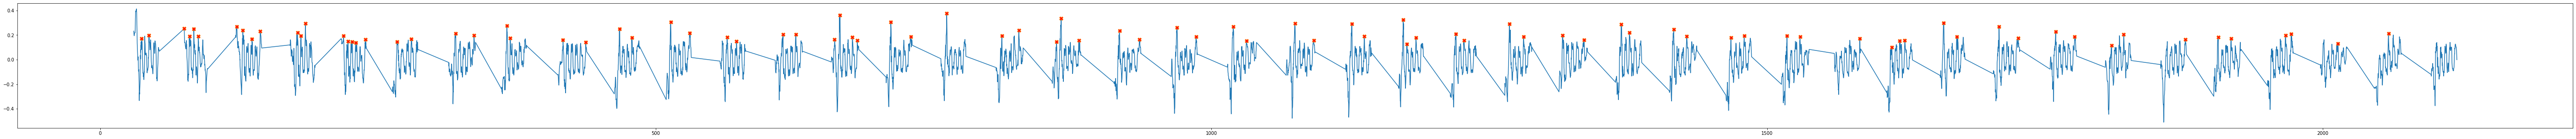

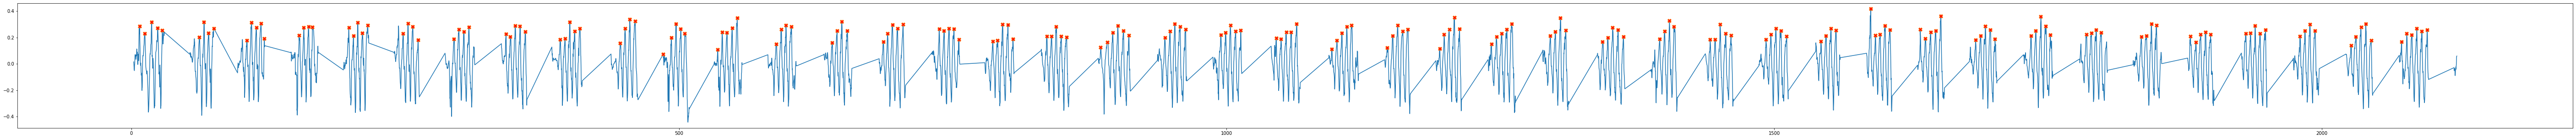

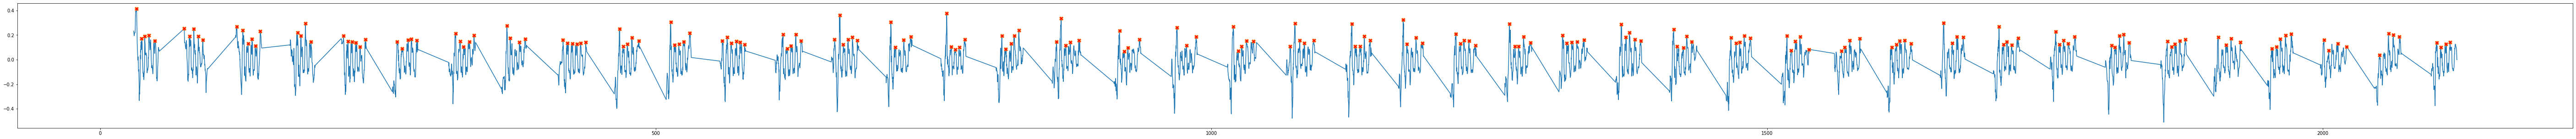

[[], [0.2028366828290439, 0.31840072729719093, 0.23374876390947227, 0.2695863044516062], [], [0.17752889781298675, 0.31408195751826223, 0.27676516792442585, 0.30620462325997133, 0.1905435580135144], [], [0.21567037493386082, 0.2764055110295752, 0.2810746495896272, 0.2795247413764667], [], [0.2755700429762151, 0.21432707232907153, 0.3122038512734955, 0.2341656393584917, 0.292060260285706], [], [0.22876626488714105, 0.30518897174544696, 0.28338326613158793, 0.18160267021383558], [], [0.18854232095851503, 0.25989501618328187, 0.24403537825018998, 0.279408038752356], [], [0.22597598894184986, 0.20444277634381433, 0.28864562417819384, 0.2844192388906273, 0.24492064382826326], [], [0.18653087772308977, 0.19305473819321833, 0.316971511068723, 0.24607055506279626, 0.2679356096616181], [], [0.15749055208917606, 0.26813085161474265, 0.33878658442898635, 0.3239199807332562], [0.07405210560501678], [0.07405210560501678, 0.19995619684094934, 0.3041019422512756, 0.2646931444231845, 0.229668637017595

In [26]:
peaks_foward=get_peaks(df_foward,df_foward.foot_left,0.3)
peaks_backward=get_peaks(df_backward,df_backward.foot_left,0.3)
#peaks = get_peaks(df_fl,df_fl.foot_left,0.2)

Time_to_index_ratio=(peaks_foward[1]-peaks_foward[0])/(df.t[peaks_foward[1]]-df.t[peaks_foward[0]])
df_foward_time=time_diff(peaks_foward,df_foward)
df_backward_time=time_diff(peaks_backward,df_backward)
foward_peaks_fl_l=remove_distinct_peaks(df_foward_time,df_foward,Time_to_index_ratio,df_foward.foot_left,0.3,0.2)
backward_peaks_fl_l=remove_distinct_peaks(df_backward_time,df_backward,Time_to_index_ratio,df_backward.foot_left,0.2,0.1)
foward_peaks_sets=sample(df_foward,df_foward.foot_left,foward_peaks_fl_l,time_return_points)
backward_peaks_sets=sample(df_backward,df_backward.foot_left,backward_peaks_fl_l,time_return_points)
print(foward_peaks_sets)
print(backward_peaks_sets)

new_foward_peaks_sets=[]
for i in range(len(foward_peaks_sets)):
    new2=[]
    for j in range(len(foward_peaks_sets[i])):       
        if foward_peaks_sets[i][j]<0.6:
            new2.append(foward_peaks_sets[i][j])
    new_foward_peaks_sets.append(new2)        

new_backward_peaks_sets=[]
for i in range(len(backward_peaks_sets)):
    new2=[]
    for j in range(len(backward_peaks_sets[i])):      
        if backward_peaks_sets[i][j]<0.6:
            new2.append(backward_peaks_sets[i][j])
    new_backward_peaks_sets.append(new2) 
    
print (new_foward_peaks_sets)
print (new_backward_peaks_sets)

fl_l_foward=list((map(lambda a : np.mean(a), new_foward_peaks_sets[plus::2])))
fl_l_backward=list((map(lambda a : np.mean(a), new_backward_peaks_sets[minus::2])))
print(fl_l_foward)
print('\n')
print(fl_l_backward)

D4=comb_dir_arrays(fl_l_foward,fl_l_backward,plus,minus)
print (D4)
print (len(D4))
D_f[2][1]=D4


# Hip to ankle distance

In [27]:
hip_nk=[]

for i in range(len(key_array)):
    t=key_array[i][28][3]
    x1=hip_ankle_right(key_array[i][28][1],key_array[i][11][0],key_array[i][12][0],key_array[i][23][0],key_array[i][24][0],key_array[i][11][1],key_array[i][12][1],key_array[i][23][1],key_array[i][24][1])
    x2=hip_ankle_left(key_array[i][27][1],key_array[i][11][0],key_array[i][12][0],key_array[i][23][0],key_array[i][24][0],key_array[i][11][1],key_array[i][12][1],key_array[i][23][1],key_array[i][24][1])
    right = key_array[i][12][0]
    left = key_array[i][11][0]
    hip_nk.append([x1])
    hip_nk[i].append(x2)
    hip_nk[i].append(t)
    hip_nk[i].append(right)
    hip_nk[i].append(left)
hip_nk = np.array(hip_nk)

df_hank = pd.DataFrame(hip_nk,columns=['hnk_right', 'hnk_left','t','r_sdr','l_sdr'])
print(df_hank)

df_foward=df_hank[df.r_sdr < df.l_sdr] 
df_backward=df_hank[df.r_sdr > df.l_sdr]
df_foward =df_foward.reset_index()
df_backward=df_backward.reset_index()
print(df_foward)
print(df_backward)



       hnk_right  hnk_left            t     r_sdr     l_sdr
0       1.311616  1.347372     2.224478  0.609468  0.658000
1       1.347493  1.363570     2.339609  0.609310  0.657366
2       1.368416  1.364600     2.455832  0.609041  0.656731
3       1.383990  1.363257     2.567967  0.608838  0.656278
4       1.384560  1.360676     2.688895  0.608436  0.655897
...          ...       ...          ...       ...       ...
18248   1.398822  1.408112  2122.812699  0.565948  0.614889
18249   1.374767  1.404973  2122.935711  0.565754  0.614945
18250   1.348249  1.413048  2123.057080  0.565708  0.614990
18251   1.353301  1.415455  2123.183629  0.566026  0.615138
18252   1.354091  1.418279  2123.304556  0.566490  0.615335

[18253 rows x 5 columns]
      index  hnk_right  hnk_left            t     r_sdr     l_sdr
0         0   1.311616  1.347372     2.224478  0.609468  0.658000
1         1   1.347493  1.363570     2.339609  0.609310  0.657366
2         2   1.368416  1.364600     2.455832  0.609041 

## hip to ankle right

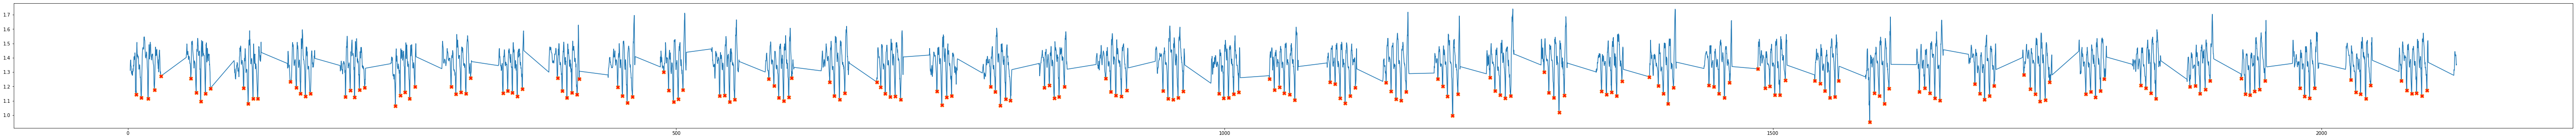

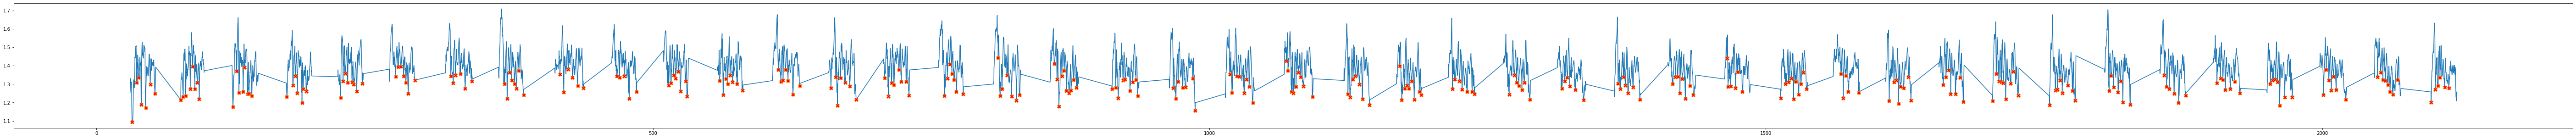

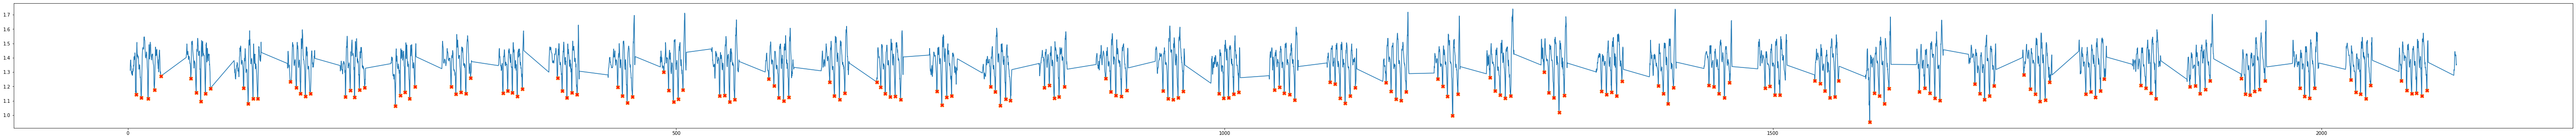

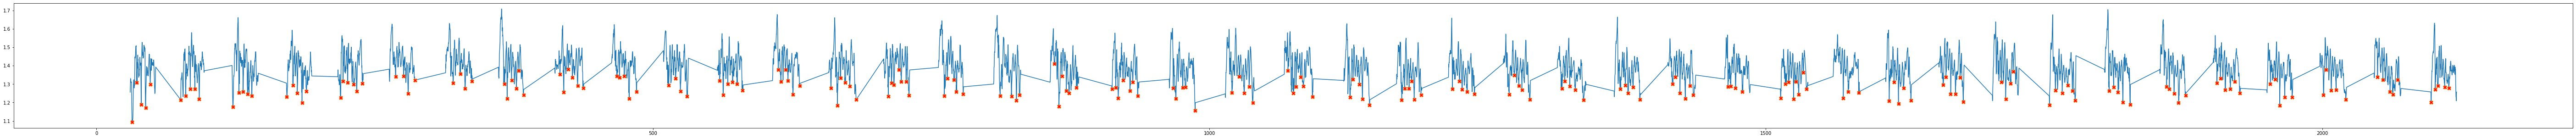

[[1.2714790624443462], [1.2549800555285247, 1.156301090911484, 1.0969136210138277, 1.1512560600314832, 1.1865214735787548], [], [1.1870356765191787, 1.0796216422589995, 1.1162248678511282, 1.1132854796244656], [], [1.2336623629776322, 1.191173574629044, 1.1511453414220645, 1.130416517274831, 1.1502381767709389], [], [1.1280468564743802, 1.1719893122637943, 1.1233037108337183, 1.1751916567997804, 1.190381409914115], [], [1.0644892542615023, 1.1368193652948129, 1.158085701853255, 1.1154228073561054, 1.1978679150835332], [], [1.1993411425946805, 1.1479803142517457, 1.1611328100156806, 1.1488362767378875, 1.2599418799950735], [], [1.1516854959387324, 1.169410190460538, 1.1571540920155783, 1.1299270548528153, 1.1808212901471953], [], [1.2603174323578679, 1.1680128957080198, 1.1213540855183945, 1.1554144534206452, 1.1423129848642315], [], [1.1933829063677746, 1.1337136381431752, 1.0868532802437656, 1.1278509945931927], [], [1.3018384815256636, 1.1711378888993482, 1.092151791959218, 1.1103384

In [28]:
peaks_foward=get_valleys(df_foward,df_foward.hnk_right,0.2)
peaks_backward=get_valleys(df_backward,df_backward.hnk_right,0.1)
Time_to_index_ratio=(peaks_foward[1]-peaks_foward[0])/(df.t[peaks_foward[1]]-df.t[peaks_foward[0]])
df_foward_right=time_diff(peaks_foward,df_foward)
df_backward_right=time_diff(peaks_backward,df_backward)
foward_peaks_R=remove_distinct_valleys(df_foward_right,df_foward,Time_to_index_ratio,df_foward.hnk_right,0.2,0.3)
backward_peaks_R=remove_distinct_valleys(df_backward_right,df_backward,Time_to_index_ratio,df_backward.hnk_right,0.1,0.4)
foward_peaks_sets=sample(df_foward,df_foward.hnk_right,foward_peaks_R,time_return_points)
backward_peaks_sets=sample(df_backward,df_backward.hnk_right,backward_peaks_R,time_return_points)
print(foward_peaks_sets)
print(backward_peaks_sets)

hnk_foward_R=list((map(lambda a : np.mean(a), foward_peaks_sets[plus::2])))
hnk_backward_R=list((map(lambda a : np.mean(a), backward_peaks_sets[minus::2])))
print(hnk_foward_R)
print('\n')
print(hnk_backward_R)

D5=comb_dir_arrays(hnk_foward_R,hnk_backward_R,plus,minus)
print (D5)
print (len(D5))
D_f[3][0]=D5

# Stride length

In [33]:
print ("X points")
foward_x= sv(df_foward,foward_peaks_R,time_return_points,key_array)
backward_x= sv(df_backward,backward_peaks_R,time_return_points,key_array)
print (foward_x)
print (backward_x)

print ("X gaps")
gap_foward= strides(foward_x)
gap_backward= strides(backward_x)
print (gap_foward)
print (gap_backward)

print ("mean strides")
foward_stride_length_R=list(map(lambda a : np.mean(a), gap_foward[plus::2]))
backward_stride_length_R=list(map(lambda a : np.mean(a), gap_backward[minus::2]))
print(foward_stride_length_R)
print('\n')
print(backward_stride_length_R)

D7=comb_dir_arrays(foward_stride_length_R,backward_stride_length_R,plus,minus)
print (D7)
print (len(D7))
D_f[4]=D7

X points
[[0.6376309990882874], [0.6382520198822021, 0.615240216255188, 0.6121013760566711, 0.6053493022918701, 0.577658474445343], [], [0.6250739693641663, 0.6471108794212341, 0.7054570913314819, 0.6620962023735046], [], [0.6936537623405457, 0.64454585313797, 0.6141858696937561, 0.5966790318489075, 0.6325538754463196], [], [0.6438526511192322, 0.6717778444290161, 0.7115122675895691, 0.7619556784629822, 0.5849153399467468], [], [0.6419426202774048, 0.6026127934455872, 0.5978122353553772, 0.5967376232147217, 0.5628335475921631], [], [0.6298103332519531, 0.6518903970718384, 0.6972385048866272, 0.7440624237060547, 0.632716715335846], [], [0.6282647252082825, 0.5994065403938293, 0.603259801864624, 0.5993654131889343, 0.6401302218437195], [], [0.6537928581237793, 0.683989942073822, 0.7381243705749512, 0.6833782196044922, 0.7678511738777161], [], [0.6441500782966614, 0.6336556673049927, 0.5939247012138367, 0.5965492725372314], [], [0.6001566052436829, 0.6243651509284973, 0.6448702216148376, 

# Stride velocity

In [36]:
df_foward_right=time_diff(foward_peaks_R, df_foward)
df_foward_right_cleaned=remove_time_gap(df_foward_right)
df_backward_right=time_diff(backward_peaks_R,df_backward)
df_backward_right_cleaned=remove_time_gap(df_backward_right)

sample_strikes_foward_R=sample_time(df_foward,foward_peaks_R,time_return_points)
sample_strikes_backward_R=sample_time(df_backward,backward_peaks_R,time_return_points)

stride_time_foward_R=strides(sample_strikes_foward_R)
stride_time_backward_R=strides(sample_strikes_backward_R)
print(stride_time_foward_R)
print('\n')
print(stride_time_backward_R)

avg_stride_foward_R=list(map(lambda a : np.mean(a), stride_time_foward_R[plus::2]))
avg_stride_backward_R=list(map(lambda a : np.mean(a), stride_time_backward_R[minus::2]))
print(avg_stride_foward_R)
print('\n')
print(avg_stride_backward_R)

Time=comb_dir_arrays(avg_stride_foward_R,avg_stride_backward_R,plus,minus)
print (Time)

velocity =[]
for i in range (len(D7)):
    velocity.append(D7[i]/Time[i])
print (velocity)
D8=velocity
print (len(D8))
D_f[5]=D8

[[], [4.903435468673706, 4.096082925796509, 4.222367525100708, 4.809759140014648], [], [4.007402181625366, 4.463486909866333, 4.194403648376465], [], [5.525373220443726, 3.9682488441467285, 4.264240980148315, 4.534103870391846], [], [4.309183597564697, 3.9421684741973877, 4.467065095901489, 4.766161918640137], [], [4.412652969360352, 4.31876540184021, 4.403473854064941, 4.676896333694458], [], [4.3949408531188965, 4.461503028869629, 4.657876968383789, 4.305530071258545], [], [4.411284685134888, 4.194200754165649, 4.356785774230957, 4.674767971038818], [], [4.251199245452881, 4.256160736083984, 4.567329168319702, 4.767872095108032], [], [4.236751556396484, 4.353791236877441, 4.8644726276397705], [], [4.495559453964233, 4.414473533630371, 4.214872598648071, 4.510525703430176], [], [4.433167219161987, 4.625755548477173, 4.656168460845947], [], [4.676264524459839, 4.403477668762207, 4.426487445831299, 4.826213121414185], [], [4.243626832962036, 4.6712682247161865, 4.814321279525757], [], [

## hip to ankle left

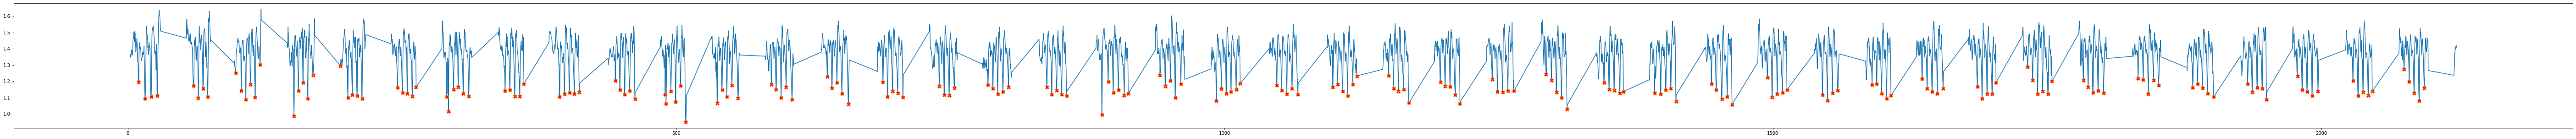

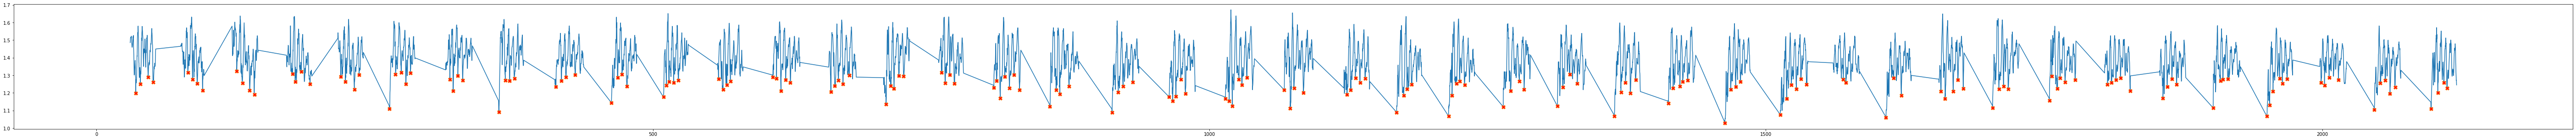

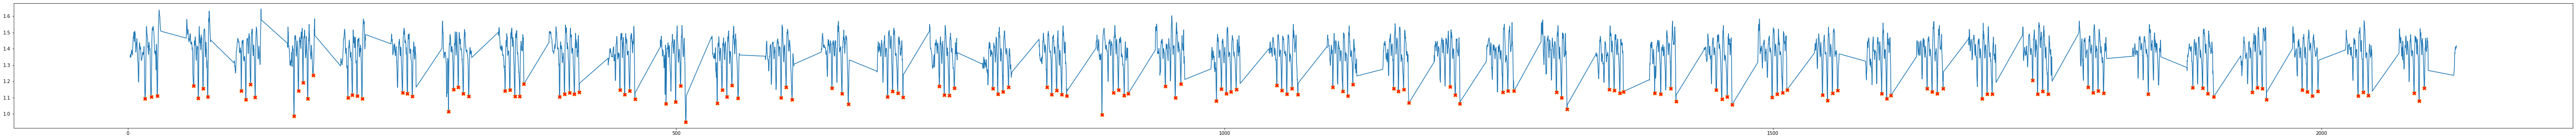

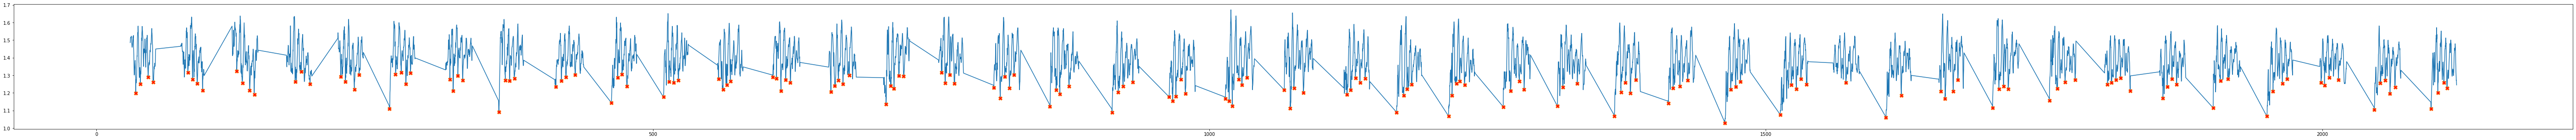

[[], [1.1732601931403885, 1.0961829567365302, 1.1559939861118846, 1.1039664860410567], [], [1.1424151698333176, 1.0883695329343395, 1.1804186989358618, 1.1021562940696938], [], [0.9868012695173718, 1.142107876894815, 1.1909499046180836, 1.0935931016633604, 1.2361720333331965], [], [1.0995937451492248, 1.1155953339275, 1.1108910698009629, 1.0944155474204358], [], [1.1311578797714845, 1.1231977503035102, 1.1066188042443916], [], [1.0132858255383692, 1.1491114947643193, 1.164907702403303, 1.1243650392963829, 1.1072816799579424], [], [1.1421116509338292, 1.1455204086158777, 1.1079576445699768, 1.1063403356029222, 1.183413269629386], [1.183413269629386], [1.1032837523419154, 1.1200993879957761, 1.1304633544837597, 1.1205170445649624, 1.131620730614427], [], [1.1464838313377246, 1.117462892869101, 1.1404239436054249, 1.0910182853995571], [], [1.0611899292976146, 1.0725983834836943, 1.171368661740996, 0.9484254151191547], [], [1.0642804555803136, 1.1466146433122344, 1.1040707820329814, 1.1744

In [37]:
peaks_foward=get_valleys(df_foward,df_foward.hnk_left,0.2)
peaks_backward=get_valleys(df_backward,df_backward.hnk_left,0.2)
Time_to_index_ratio=(peaks_foward[1]-peaks_foward[0])/(df.t[peaks_foward[1]]-df.t[peaks_foward[0]])
df_foward_left=time_diff(peaks_foward,df_foward)
df_backward_left=time_diff(peaks_backward,df_backward)
foward_peaks_L=remove_distinct_valleys(df_foward_left,df_foward,Time_to_index_ratio,df_foward.hnk_left,0.3,0.3)
backward_peaks_L=remove_distinct_valleys(df_backward_left,df_backward,Time_to_index_ratio,df_backward.hnk_left,0.2,0.4)
foward_peaks_sets=sample(df_foward,df_foward.hnk_left,foward_peaks_L,time_return_points)
backward_peaks_sets=sample(df_backward,df_backward.hnk_left,backward_peaks_L,time_return_points)
print(foward_peaks_sets)
print(backward_peaks_sets)

hnk_foward_L=list((map(lambda a : np.mean(a), foward_peaks_sets[plus::2])))
hnk_backward_L=list((map(lambda a : np.mean(a), backward_peaks_sets[minus::2])))
print(hnk_foward_L)
print('\n')
print(hnk_backward_L)

D6=comb_dir_arrays(hnk_foward_L,hnk_backward_L,plus,minus)
print (D6)
print (len(D6))
D_f[3][1]=D6

In [ ]:
output = open('para_values/{}.pkl'.format(name), 'wb')
pickle.dump(T_f, output)
output.close()